# Introduction
Consider that the Data Science team at AIIMS hospital has built a Neural Network which predicts if a patient has diabetes or not.

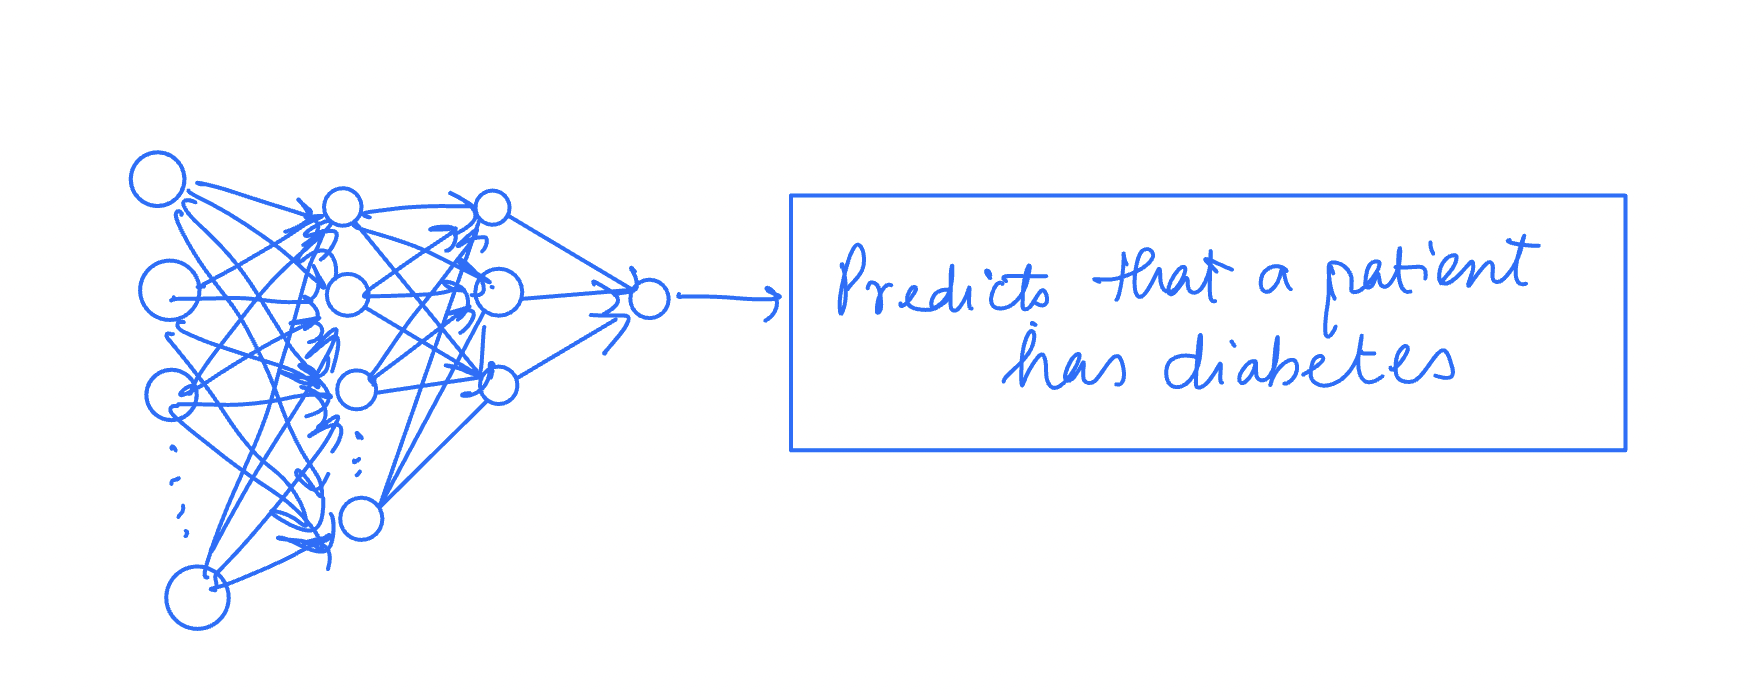

Say that if a Doctor wants to know which features caused the Neural Network to predict that a patient is diabetic.

Clearly, it is impossible to say, as there are many weight parameter values and it is not possible to say which weight parameter is associated with which input feature.

The requirement is for a simpler model that represents the Neural Network model. Using this simple model, it is fairly possible to determine the features that are important.

Finding the important features or feature that contribute to the output is called Interpretability or Explanability.

# LIME
LIME stands for Local Interpretable Model-Agnostic Explanations.

LIME is used to explain the predictions made by ML models. LIME is a popular technique for interpreting individual predictions of black-box models. It approximates the local behavior of a model by creating a local interpretable model which helps in understanding why a model makes a specific prediction for a given instance.

# Understanding Global Analysis And Local Analysis

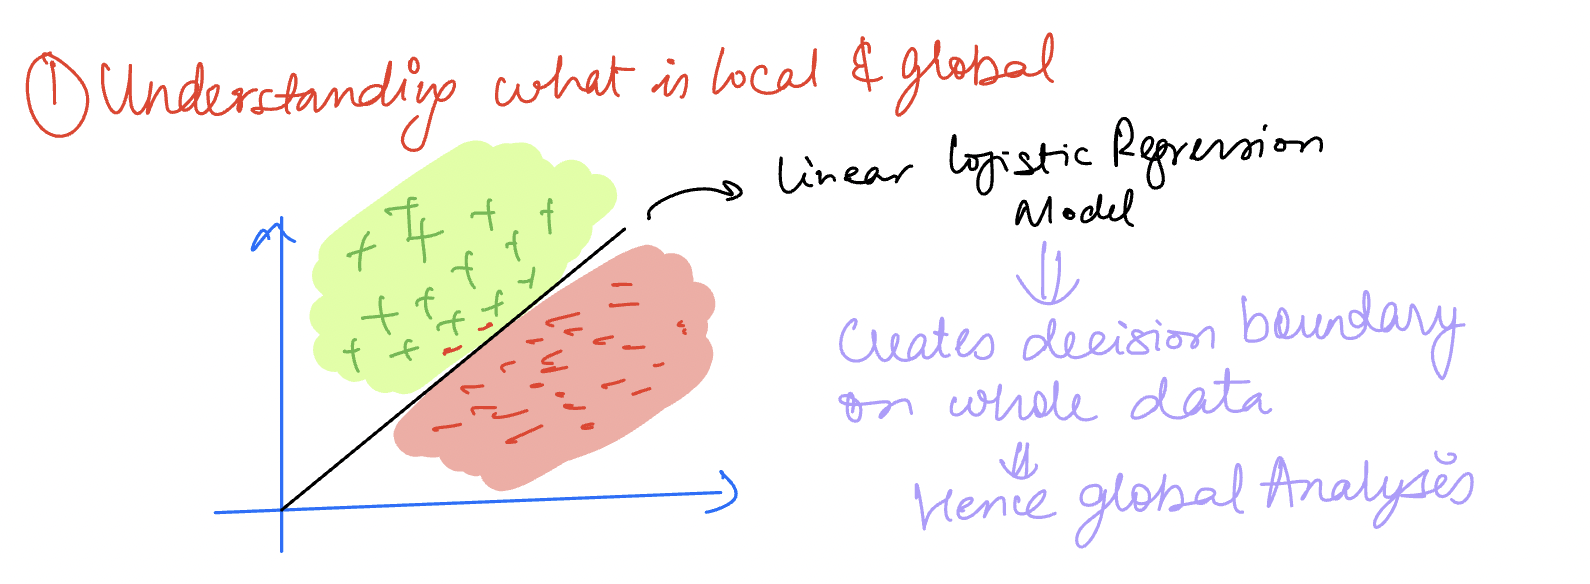

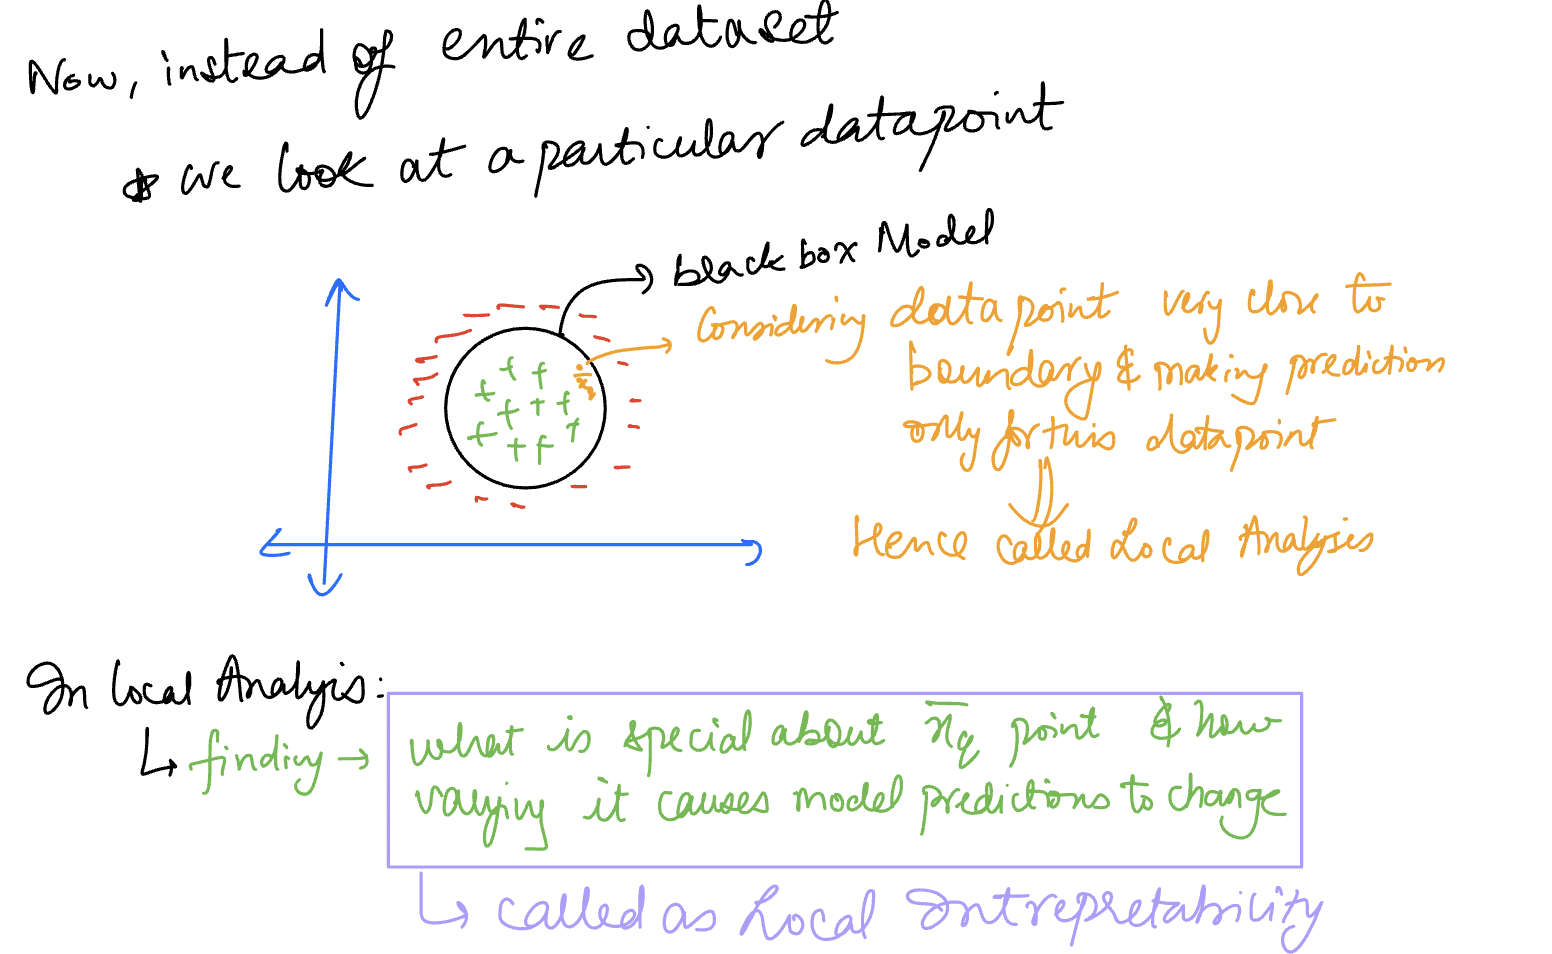

# Understanding Locality Of Interest

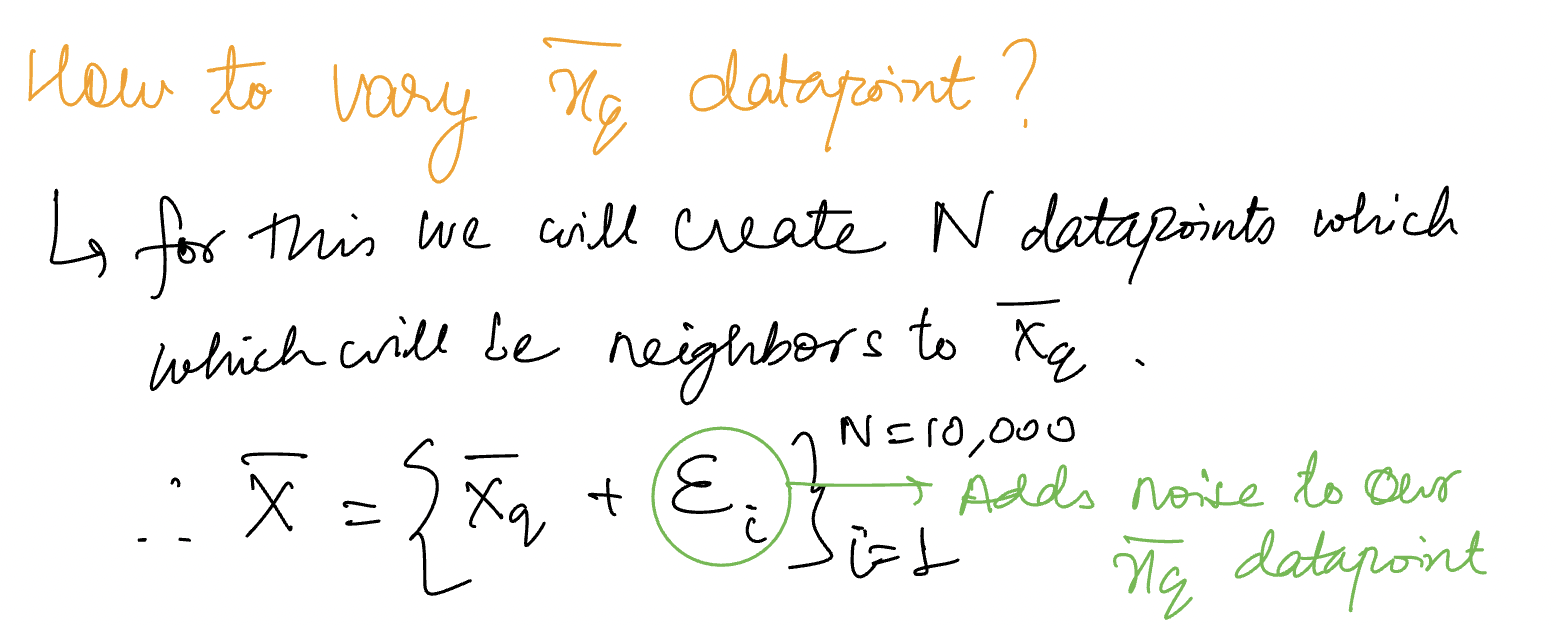

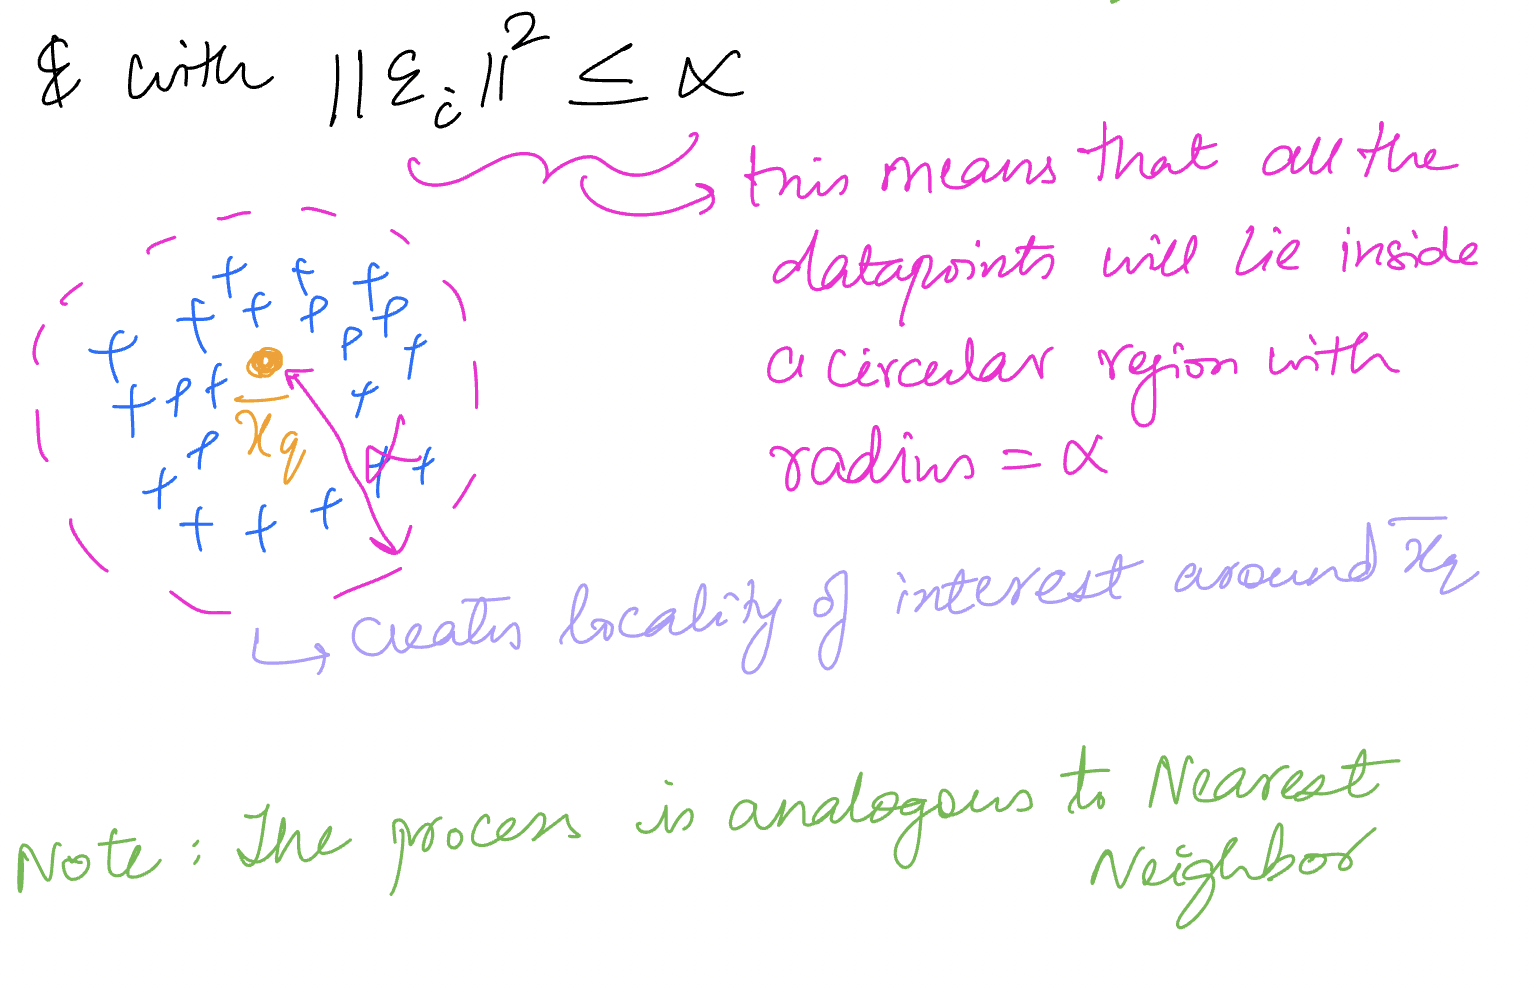

These Locality of Interest points show how fluctuating features affect the model performance.

# Understanding Model Agnostics
For different models, different Interpretability techniques are used.
- For a Linear Regression model, weights of the model serve as a mean for Interpretability.
- For a Decision Tree model, the features that are selected for split in every level serve as mean for Interpretability.

# Is LIME Used Only For Neural Networks?
No, LIME is a general interpretability technique and hence can be used for any model. Therefore, LIME is model agnostic.

# What Does LIME Offer On Model Interpretability?
1. A consistent model agnostic explainer.
2. A method to select a representative set with explnations [SP-LIME] to make sure the model behaves consistently while replicating human logic. This representative set would provide an intuitive global understanding of the model.

LIME explains a prediction so that even the non-exprets could compare and improve on an untrustworthy model through feature engineering.

# LIME Process
1. Select a local point $\bar{x_q}$.
2. Create $N$ datapoints within the radius of $\alpha$ of $\bar{x_q}$ by introducing noise to the local points.
3. Pass all the points in the new dataset to the model.
4. Make a new interpretable (simpler) model to learn on the newly created dataset. This newly created interpretable model uses K-Lasso as the loss function.

K-Lasso finds the top K features using L1 regularization.

# LIME Loss Function
Let,
- $\bar{x_q}$ = A local point.
- $\bar{x_q}'$ = Neighborhood point.
- $f(\bar{x_q})$ = The model.
- $g(\bar{x_q}')$ = Interpretable model

The Interpretable model has to approximate the $f$ model and the model needs to be simple. It is measured using $\Omega(g)$.

Therefore, $\text{Total Loss} = \argmin L(f, g, \bar{x_q}') + \Omega(g), g \in G$. Where, $G$ represents all possible interpretable models.

$L(f, g, \bar{x_q}')$ measures how similar $g$ is to $f$.

$\Omega(g)$ is the K-Lasso penalty which selects K features using Lasso regularization.

Further reading: https://towardsdatascience.com/decrypting-your-machine-learning-model-using-lime-5adc035109b5

# Implementation Of LIME

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# loading the breast cancer dataset
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
breast_cancer

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [3]:
for line in breast_cancer.DESCR.split("\n")[5: 32]:
    print(line)

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - class:
            - WDBC-Malignant
            - WDBC-Benign



In [4]:
x, y = breast_cancer.data, breast_cancer.target
x.shape, y.shape

((569, 30), (569,))

In [5]:
breast_cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [6]:
print(f"Features: {x[300]}\n\nTarget: {y[300]}")

Features: [1.953e+01 1.890e+01 1.295e+02 1.217e+03 1.150e-01 1.642e-01 2.197e-01
 1.062e-01 1.792e-01 6.552e-02 1.111e+00 1.161e+00 7.237e+00 1.330e+02
 6.056e-03 3.203e-02 5.638e-02 1.733e-02 1.884e-02 4.787e-03 2.593e+01
 2.624e+01 1.711e+02 2.053e+03 1.495e-01 4.116e-01 6.121e-01 1.980e-01
 2.968e-01 9.929e-02]

Target: 0


In [7]:
# splitting the into train and test set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.9, test_size = 0.1, stratify = y, random_state = 123)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((512, 30), (512,), (57, 30), (57,))

In [8]:
# building a simple classifier model
model_1 = Sequential(
    [
        Dense(64, activation = tf.nn.relu),
        Dense(16, activation = tf.nn.relu),
        Dense(2, activation = tf.nn.softmax)
    ]
)

model_1.build(x_train.shape)

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (512, 64)              │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (512, 16)              │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (512, 2)               │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,058 (11.95 KB)

 Trainable params: 3,058 (11.95 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# compiling the model
model_1.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

# training the model
model_1.fit(x_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5864 - loss: 102.9818  
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5106 - loss: 10.4724 
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8382 - loss: 1.1369 
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9070 - loss: 0.7365 
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9153 - loss: 0.5437
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9081 - loss: 0.4499 
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9060 - loss: 0.5454 
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9007 - loss: 0.4012 
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9014 - loss: 0.5250 
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9061 - loss: 0.5303 
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9035 - loss: 0.4918 
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accurac

In [10]:
predictions = model_1.predict(x_test)
predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[1.00000000e+00, 2.86992667e-31],
       [1.37605801e-01, 8.62394273e-01],
       [1.00000000e+00, 1.52537060e-15],
       [1.08251406e-03, 9.98917401e-01],
       [2.37554568e-03, 9.97624397e-01],
       [1.00000000e+00, 4.99537345e-09],
       [3.72668244e-02, 9.62733150e-01],
       [3.05350095e-01, 6.94649875e-01],
       [7.42852569e-01, 2.57147372e-01],
       [1.00000000e+00, 1.26903587e-13],
       [2.43478119e-02, 9.75652277e-01],
       [5.45661211e-01, 4.54338819e-01],
       [9.99981105e-01, 1.90041501e-05],
       [1.00822828e-03, 9.98991787e-01],
       [9.84703779e-01, 1.52962394e-02],
       [5.02017885e-02, 9.49798226e-01],
       [2.90654041e-03, 9.97093499e-01],
       [9.99999881e-01, 1.61351764e-07],
       [8.79388928e-01, 1.20611064e-01],
       [1.02928750e-01, 8.97071183e-01],
       [9.41806957e-02, 9.05819356e-01],
       [9.99996066e-01, 3.94743756e-06],
       [1.09014836e-04, 9.99890924e-01],
       [1.00000000e+00, 2.72231515e-10],
       [9.999571

In [11]:
y_pred = np.argmax(predictions, axis = 1)
y_pred

array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1])

In [12]:
# computing the accuracy
acc = tf.keras.metrics.Accuracy()
acc(y_test, y_pred).numpy()

np.float32(0.8947368)

### Implementing LIME

`pip install lime`

### How does LIME work?
At start, an image from a particular locality is selected. A locality usually represents a single data point. In this particular case, the data point is an image.

Once the above is done, the following is carried out,
- Data perturbation: Create modified instances from locality by randomly changing features while keeping the label unchanged.
- Model prediction: Pass the perturbed instances through the black-box model and record the predictions.
- Feature extraction: Extract relevant features from the perturbed instances and encode them appropriately.
- Local model fitting: Build a simpler, interpretable model (explainer model) to approximate the black-box model's behavior locally.
- Weights calculation: Assign weights to the perturbed instances based on their proximity o the instance of interest.
- Explanation generation: Combine the predictions of the explainer model with feature importance to generate explanations.

The explanations highlight the most influential features for the black-box model's prediction on a specific instance, providing insights into the decision-making process. LIME offers local explanations and helps understand the complex and opaque models.

In [13]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(x_train, mode = "classification", class_names = breast_cancer.target_names, feature_names = breast_cancer.feature_names)
explainer

### Model Interpretability with LIME

In [14]:
# start by implementing an end-to-end interpretability algorithm with LIME
import random

# taking a correct instance
idx = random.randint(1, len(x_test))
print(f"Prediction: {breast_cancer.target_names[np.argmax(model_1.predict(x_test[idx].reshape(1, -1)))]}")
print(f"Actual: {breast_cancer.target_names[y_test[idx]]}")

explanation = explainer.explain_instance(x_test[idx], model_1.predict, num_features = len(breast_cancer.feature_names))
explanation.show_in_notebook()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: malignant
Actual: malignant
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


Observe the following,
1. First plot shows the prediction probability of the class.
2. Second plot shows how each feature is influencing the prediction.
3. Third plot shows the features which led to the output of the model as "benign".

In [15]:
# taking an incorrect instance
predictions = np.argmax(model_1.predict(x_test))

false_predictions = np.argwhere(predictions != y_test).flatten()
false_predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([ 1,  3,  4,  6,  7,  8, 10, 13, 14, 15, 16, 18, 19, 20, 22, 25, 26,
       30, 32, 33, 34, 36, 38, 39, 40, 41, 42, 43, 45, 46, 47, 49, 50, 51,
       52, 56])

In [16]:
idx = random.choice(false_predictions)
print(f"Prediction: {breast_cancer.target_names[np.argmax(model_1.predict(x_test[idx].reshape(1, -1)))]}")
print(f"Actual: {breast_cancer.target_names[y_test[idx]]}")

explanation = explainer.explain_instance(x_test[idx], model_1.predict)
explanation.show_in_notebook()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: benign
Actual: benign
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


Observe the following,
1. First plot shows the prediction probability of the class.
2. Second plot shows how each feature is influencing the prediction,
    - Clearly the worst area feature influences the model prediction.
    - Also, the mean area feature makes the model think that the cancer is benign.
3. Third plot shows the features which led the model to predict the output as malignant.

# Advantages And Disadvantages Of LIME
### Advantages
1. Model agnostic: LIME works with every model.
2. LIME can be used for text, tabular and image data.
3. LIME makes use of Lasso regression, which is highly interpretable.
4. By defining a simple locality, LIME solves the problem of interpreting complex models.

### Disadvantages
1. Very sensitive to hyperparameters $\alpha$ and $K$ values.
2. Sensitive to neighborhood.
3. Uses distance as metric to find locality of interest. The problem with this is that, different distances can lead to different localities.

# SHAP: Alternative Way To Find Interpretability

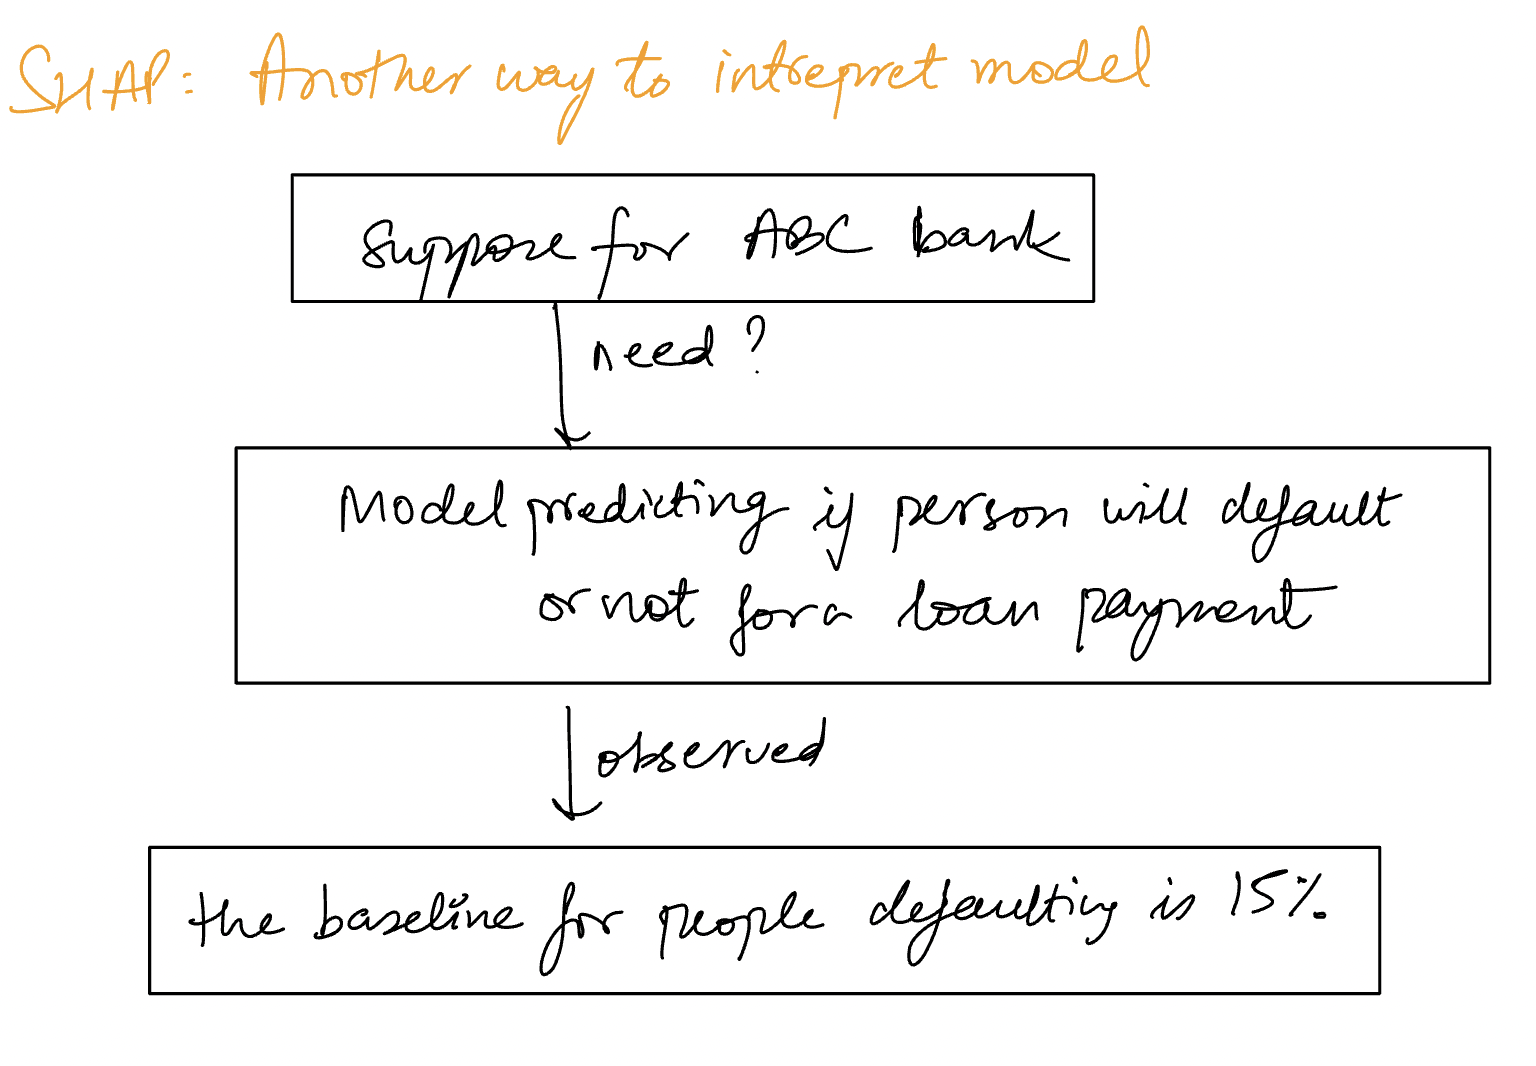

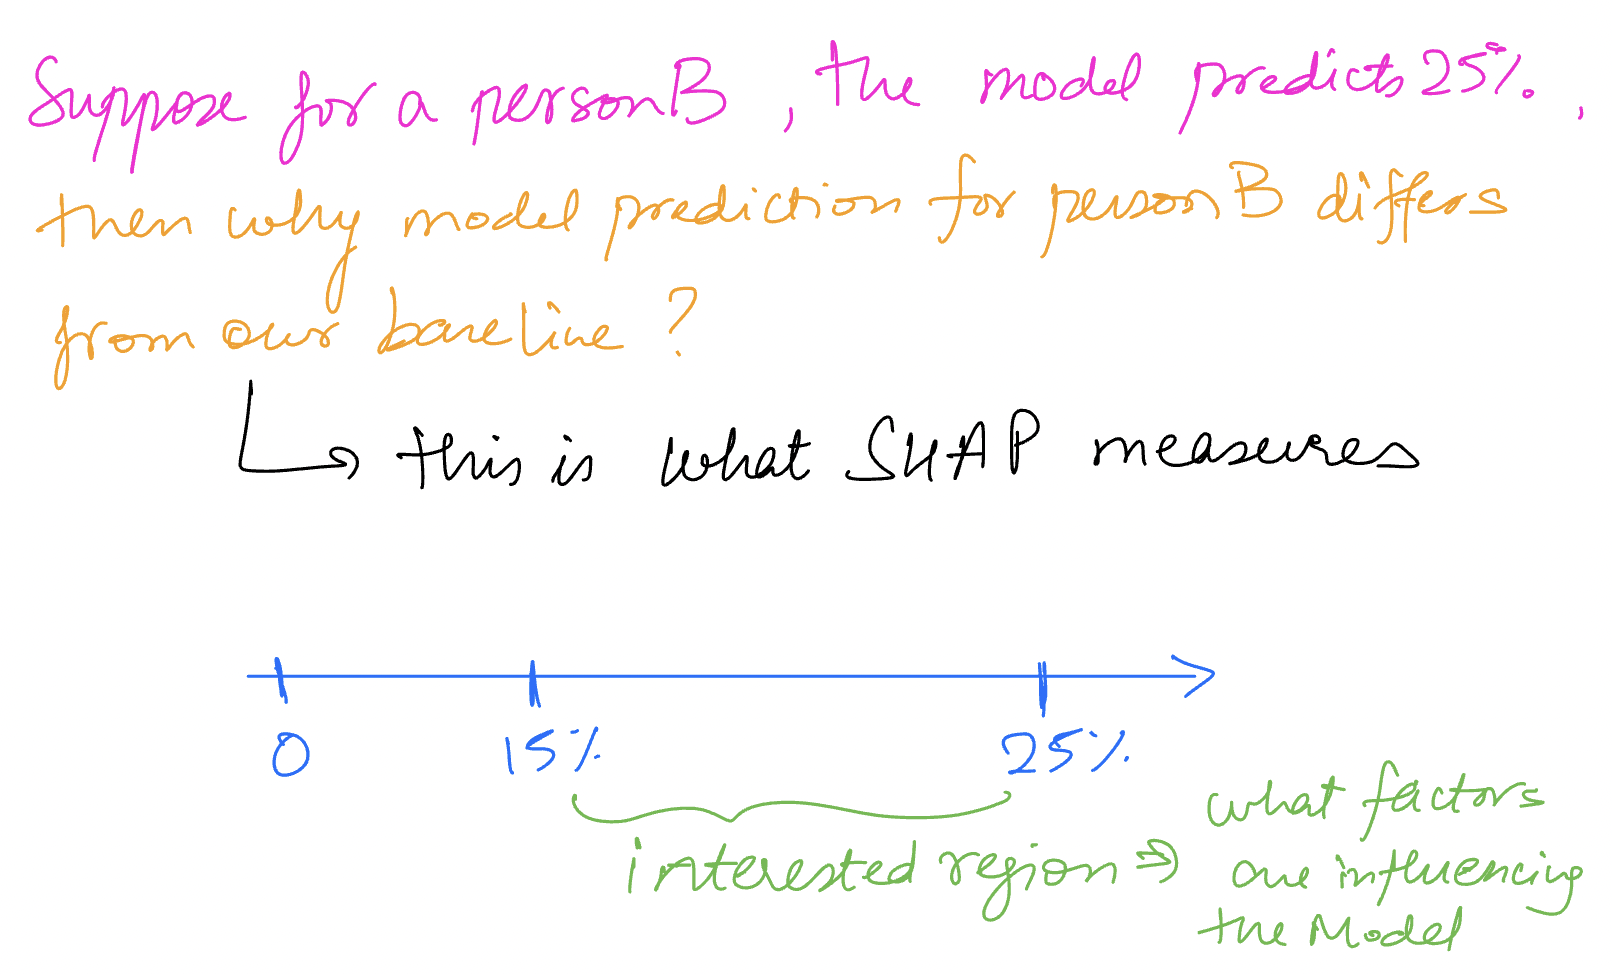

SHAP stands for SHapley Additive exPlantations. SHAP is a method in cooperative game theory that enhances the transparency and interpretability of ML models. It provides a unified framework for attributing the contributions of each feature towards a prediction, addressing the limitations of traditional linear models and feature importances in tree-based models.

Unlike linear models that rely on feature coefficients, which may be influenced by varable scales and fail to capture local importance, SHAP values offer a more comprehensive understanding of feature importance. They consider the impact of each feature when combined with different subsets of features, accounting for interactions and dependencies among them.

SHAP values are based on the concept of Shapley values from cooperative game theory. By calculating the marginl contribution of a feature when added to or removed from coalitions of features, SHAP values ensure fairness and consistecy in attributing importance.

The insights provided by SHAP values are interpretable and nuanced, revealing the relative importance of each feature in a prediction. Visualizations, such as summary plots, individual feature importance plots, dependence plots, or force plots, allow for a detailed exploration of feature impact on predictions.

### Example 1 to understand SHAP

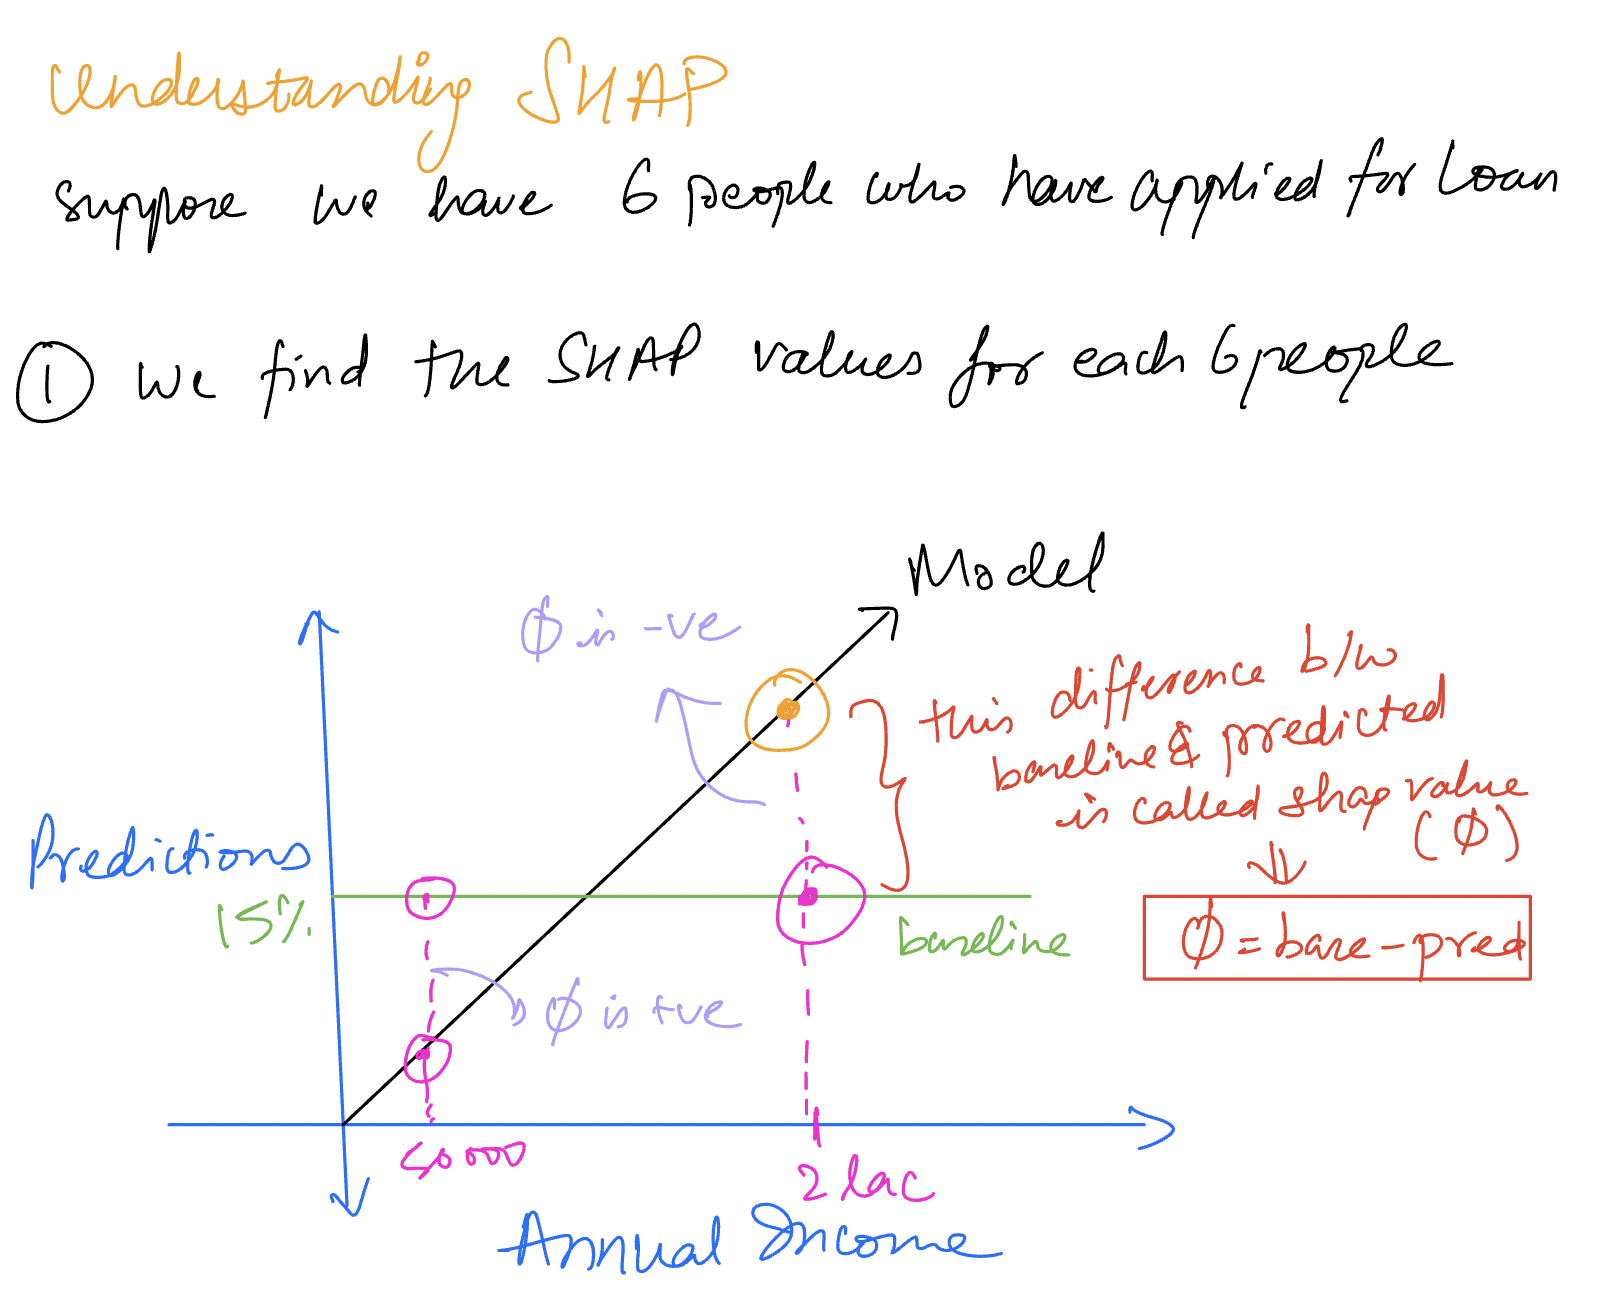

For each of the 6 people, the difference between the base and the predicted defaulting % is found. They are labelled as, ${\phi_1, \phi_2, \phi_3, \phi_4, \phi_5, \phi_6}$.

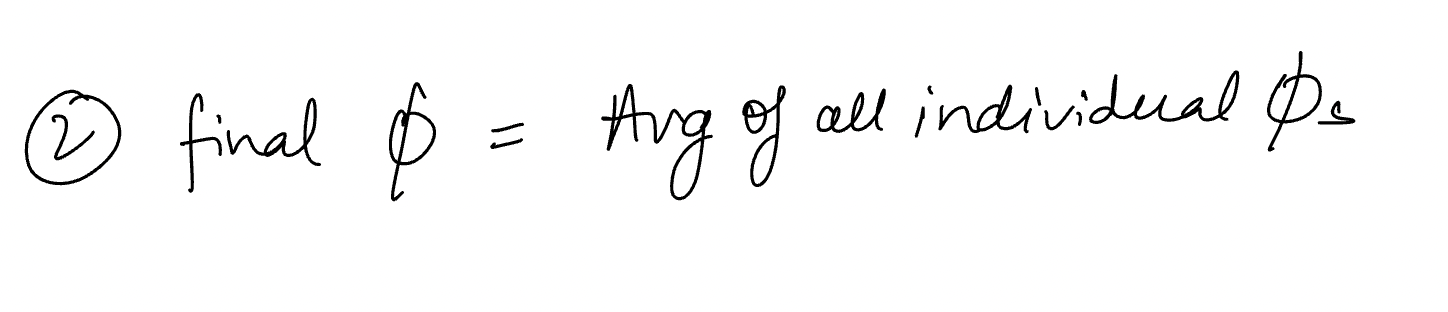

For final $\phi$, the average of all the values, i.e., ${\phi_1, \phi_2, \phi_3, \phi_4, \phi_5, \phi_6}$ is found,
- $\phi = \frac{\phi_1 + \phi_2 + \phi_3 + \phi_4 + \phi_5 + \phi_6}{6}$.

### Example 2 to understand SHAP
Shapley values are a concept in the field of cooperative game theory introduced by Lloyd Shapley in 1953. They aim to measure the contribution of each player in a game. In the context of ML models, Shapley values can be used to assess the interpretability of these models.

To calculate the Shapley value of a feature in an ML model, they are considered as a player in a game. The game is the function that generates predictions, and the "profit" corresponds to the prediction itself. The Shapley value of a feature represents its average marginal contribution among all possible coalitions.

For example, consider a group of friends (A, B, C, D) working together to obtain a profit P. To distribute the profit fairly, the Shapley value of each friend is calculated. To do this, the difference between the profit generated when the friend is present and the profit generated when they are absent (marginal contribution) is computed. This calculation is performed for all possible subgroups where the friend is present. The Shapley value is then obtained by averaging these marginal contributions.

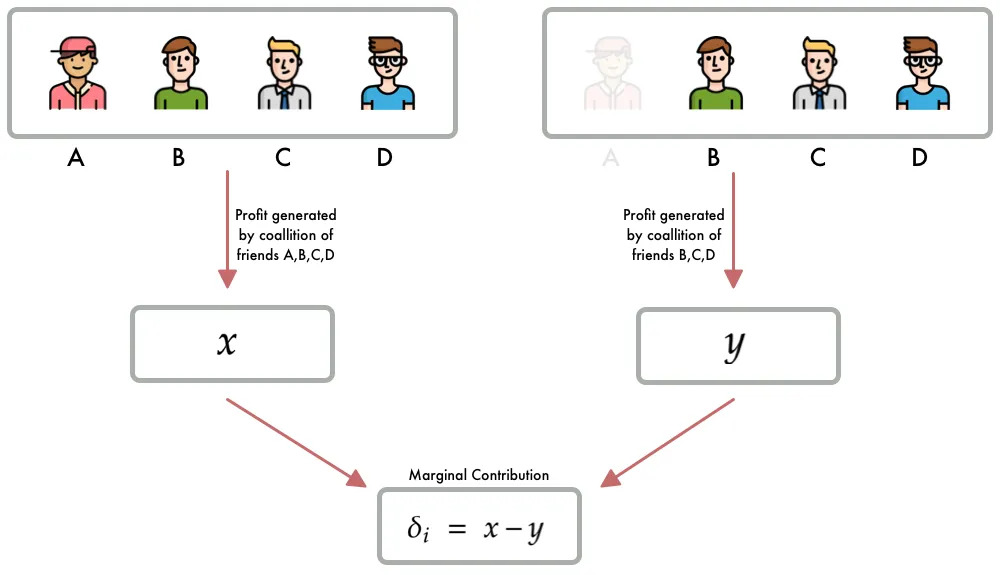

Below figures shows the representation of the calculation of the Shapley value for the friend A. However, calculating Shapley values for each instance of each feature in an ML model can be computationally challenging, especially when dealing with a large number of features. This problem is known to be NP-hard.

This is where SHAP (SHapley Additive exPlanations) comes into play. SHAP provides an approach to interpreting ML models. It addresses the computational complexity by approximating Shapley values using various techniques. By utilizing SHAP, insights into the contribution of each feature to the predictions made by an ML model can be gained, enhancing the interpretability of the model.

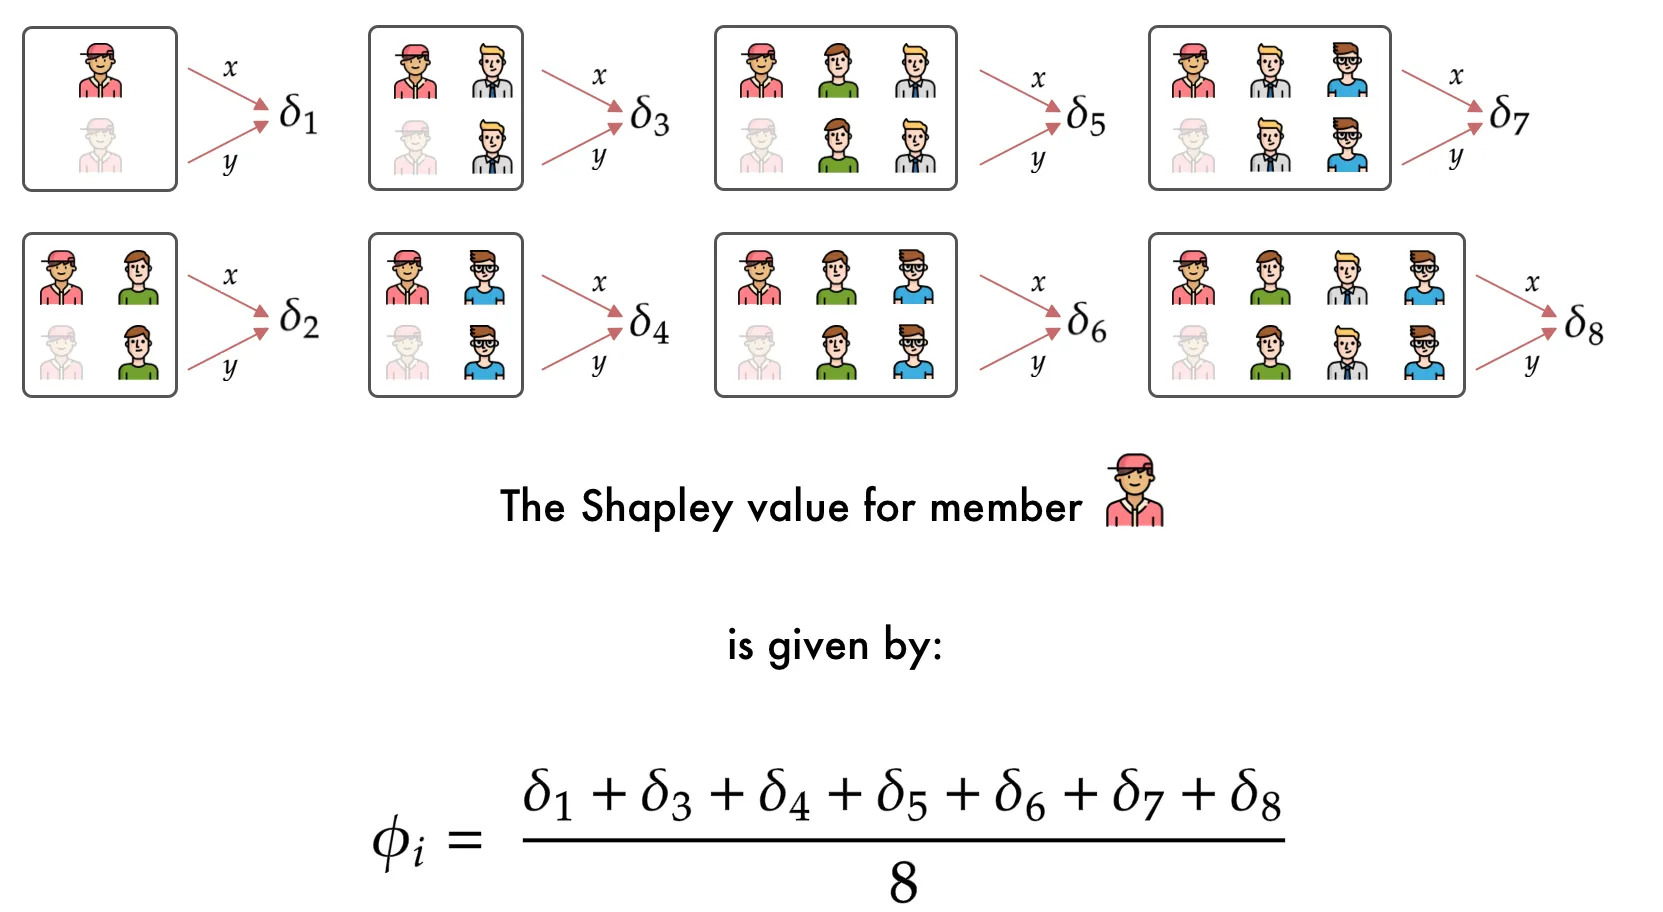

### Implementation of SHAP

`pip install shap`

Similar to LIME, an end-to-end algorithm is built to understand SHAP.

Further reading: https://shap.readthedocs.io/en/latest/generated/shap.KernelExplainer.html

In [17]:
import shap

explainer = shap.KernelExplainer(model_1.predict, x_train)

# finding the shap_values is a time intensive process
shap_values = explainer.shap_values(x_test, nsamples = 100)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


Using 512 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/57 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
1/1 

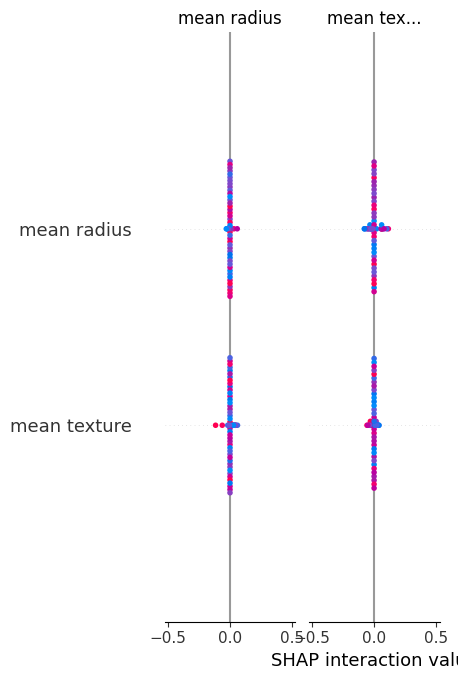

In [18]:
shap.summary_plot(shap_values, x_test, feature_names = breast_cancer.feature_names)

Each point of every row is a record of the test dataset. The features are sorted from the most important to the least important.

# SHAP Algorithm
In order to calculate SHAP, the following is done,
- Choose a referene point as a baseline for feature contribution measurement.
- Explore all feature permutations for a specific instance.
- Evaluate each feature's contribution by comparing predictions with and without the feature.
- Apply the Shapley value formula to calculate the feature importance.
- Interpret positive or negative SHAP values as positive or negative contributions.

SHAP values offers a comprehensive way to understand feature importance, accounting for interactions and dependencies, aiding interpretation of complex models.